### Cephalo: Merging models and training

Markus J. Buehler, MIT

mbuehler@MIT.EDU

```bibtxt
@article{Buehler_Cephalo_2024,
    title   = {Cephalo, a series of multi-modal vision-language models for 
    bio-inspired materials and mechanics},
    author  = {M.J. Buehler},
    journal = {arXiv},
    year    = {2024},
    volume  = {},
    pages   = {},
    url     = {}
}
```

In [ ]:
import os

DEVICE='cuda'

import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from datasets import Dataset, DatasetDict
from huggingface_hub import HfFolder, HfApi
import copy
import torch
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration, AutoTokenizer
from datetime import datetime
import random
from tqdm.notebook import tqdm

torch.__version__

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params/1e9, trainable_params/1e9

### Load base models

In [5]:
model_1_id='lamm-mit/Cephalo-Idefics-2-vision-8b-beta'
model_2_id='HuggingFaceM4/idefics2-8b-chatty'

name_1=model_1_id.split('/')[-1]
name_2=model_2_id.split('/')[-1]
name_1, name_2

('Cephalo-Idefics-2-vision-8b-beta', 'idefics2-8b-chatty')

In [ ]:
model_1 = Idefics2ForConditionalGeneration.from_pretrained( model_1_id, torch_dtype=torch.bfloat16,
                                       #_attn_implementation="flash_attention_2",
                                                        ).to (DEVICE )
model_2 = Idefics2ForConditionalGeneration.from_pretrained( model_2_id, torch_dtype=torch.bfloat16,
                                       #_attn_implementation="flash_attention_2",
                                                        ).to (DEVICE )

In [ ]:
count_parameters(model_1)

In [ ]:
count_parameters(model_2)

In [ ]:
model_1

In [ ]:
processor = AutoProcessor.from_pretrained(
    f"{model_1_id}",
    #do_image_splitting=False
    do_image_splitting=True
)

In [ ]:
save_on_disk=False
if save_on_disk:
    processor.save_pretrained ('model_1')
    processor.save_pretrained ('model_2')
    
    model_1.model.text_model.save_pretrained ('model_1' )
    model_2.model.text_model.save_pretrained ('model_2' )

In [ ]:

model_merged=copy.deepcopy(model_1)
 

### Build new model 

In [ ]:
from torch import nn

N_t=32
N_m=8

# Select layers N_t-N_m....N_t from model_2
selected_layers_from_model2 = list(model_2.model.text_model.layers)[N_t-N_m:N_t]

# Concatenate all layers from model1 with selected layers from model2
combined_layers = nn.ModuleList(list(model_1.model.text_model.layers) + selected_layers_from_model2)

# Assign combined layers to model1
model_merged.model.text_model.layers = combined_layers

In [ ]:
model_merged

In [ ]:
merged_name=f'{name_1}-{name_2}_merged'

repo_id='xxxxx/' #<repo_ID>
model_merged.push_to_hub (repo_id+merged_name, )
processor.push_to_hub (repo_id+merged_name, )

save_on_disk=False
if save_on_disk:
    model_merged.save_pretrained (merged_name)
    processor.save_pretrained (merged_name)

print ('Model created at: ', repo_id+merged_name)

### Load model

In [ ]:

base_model_id=repo_id+merged_name
model = Idefics2ForConditionalGeneration.from_pretrained( base_model_id, torch_dtype=torch.bfloat16,
                                       _attn_implementation="flash_attention_2",
                                                        ).to (DEVICE )

processor = AutoProcessor.from_pretrained(
    base_model_id,
    do_image_splitting=True
)

for name, param in model.named_parameters():
    # Freeze all parameters
    param.requires_grad = False

# Unfreeze the last N_m layers of the text_model
for i in range(-N_m, 0):  # Last 8 layers
    layer = model.model.text_model.layers[i]
    for param in layer.parameters():
        param.requires_grad = True

# Verify the layers that will be trained
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

count_parameters(model)

### Train model

Load dataset, set up data collator, set up trainer, then train

#### Load dataset

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("lamm-mit/Cephalo-Wikipedia-Materials", split="train")


Generating train split:   0%|          | 0/8188 [00:00<?, ? examples/s]

In [3]:
train_dataset[10]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=220x165>,
 'query': 'What is shown in this image?',
 'answer': "The image displays the microstructure of sepiolite in solid form within the shells of mollusks. It reveals a hierarchical arrangement of nanoscale crystals that contribute to its mechanical strength and durability, providing structural support and protection for the animal's soft body parts. The composition of sepiolite varies depending on the species of mollusk it is found in, but generally consists primarily of calcium carbonate and organic materials.",
 'orig_caption': 'Sepiolite in solid form',
 'image_url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/Sepiolite-469730.jpg/220px-Sepiolite-469730.jpg',
 'url': 'https://en.wikipedia.org/wiki/Biomimetics'}

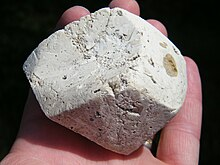

In [4]:
train_dataset[10]["image"]

In [ ]:
import random

prepend_text="Answer briefly."
class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = example["image"]
            question = example["query"]
            answer = example["answer"]
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prepend_text},
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100
        labels[labels == self.image_token_id] = -100
        batch["labels"] = labels

        return batch

data_collator = MyDataCollator(processor)

#### Set up trainer

In [ ]:
from transformers import TrainingArguments, Trainer

optim = "paged_adamw_8bit"

training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=1,
    #per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=250,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_steps=25,
    output_dir="output_training",
    optim=optim,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=16,
    #fp16=True,
    bf16=True,  
    push_to_hub_model_id=repo_id+"fine_tuned_model",
    remove_unused_columns=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    # eval_dataset=eval_dataset, #   
)

#### Train

In [ ]:
trainer.train()